In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd
import copy

Setting a random seed value (SEED) to ensure reproducibility of the results when working with random operations in deep learning models.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Mounting the google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Loading the dataset from the drive 

In [4]:
# Unpack the dataset zip file
import shutil
shutil.unpack_archive("/content/drive/MyDrive/DeepLearning/Retinal OCT_M.zip","Dataset")

Image transformation into 32 x 32 pixels

In [5]:
batch_size = 32
transform_train = transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    transforms.Resize((32,32)),
    #torchvision.transforms.RandomResizedCrop(32, scale=(0.08, 1.0),
    #                                         ratio=(3.0/4.0, 4.0/3.0)),
    #torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    #torchvision.transforms.ColorJitter(brightness=0.4,
    #                                   contrast=0.4,
    #                                   saturation=0.4),
    # Add random noise
    transforms.ToTensor(),
    # Standardize each channel of the image
    transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
   ])

transform_test = transforms.Compose([
    transforms.Resize((32,32)),
    # Crop a 224 x 224 square area from the center of the image
    #torchvision.transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
   ])

 Spliting the dataset is organized into different folders: 'train', 'val' (validation), and 'test'.

In [6]:
data_dir = '/content/Dataset/Retinal OCT Dataset (Original) - Copy'

train_ds, train_valid_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_train) for folder in ['train', 'train']]

valid_ds, test_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_test) for folder in ['val', 'test']]

The data loaders provide an iterable object that can be used in a for loop to iterate over the data in batches. 

In [7]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

Represents the mean and standard deviation of image pixel values for RGB channels respectively

In [8]:
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_ds:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_ds)
stds /= len(train_ds)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([-1.2600, -1.1586, -0.9313])
Calculated stds: tensor([0.7650, 0.7821, 0.7786])


Normalizing the pixel values which can help in improving the performance and convergence of deep learning models.

In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

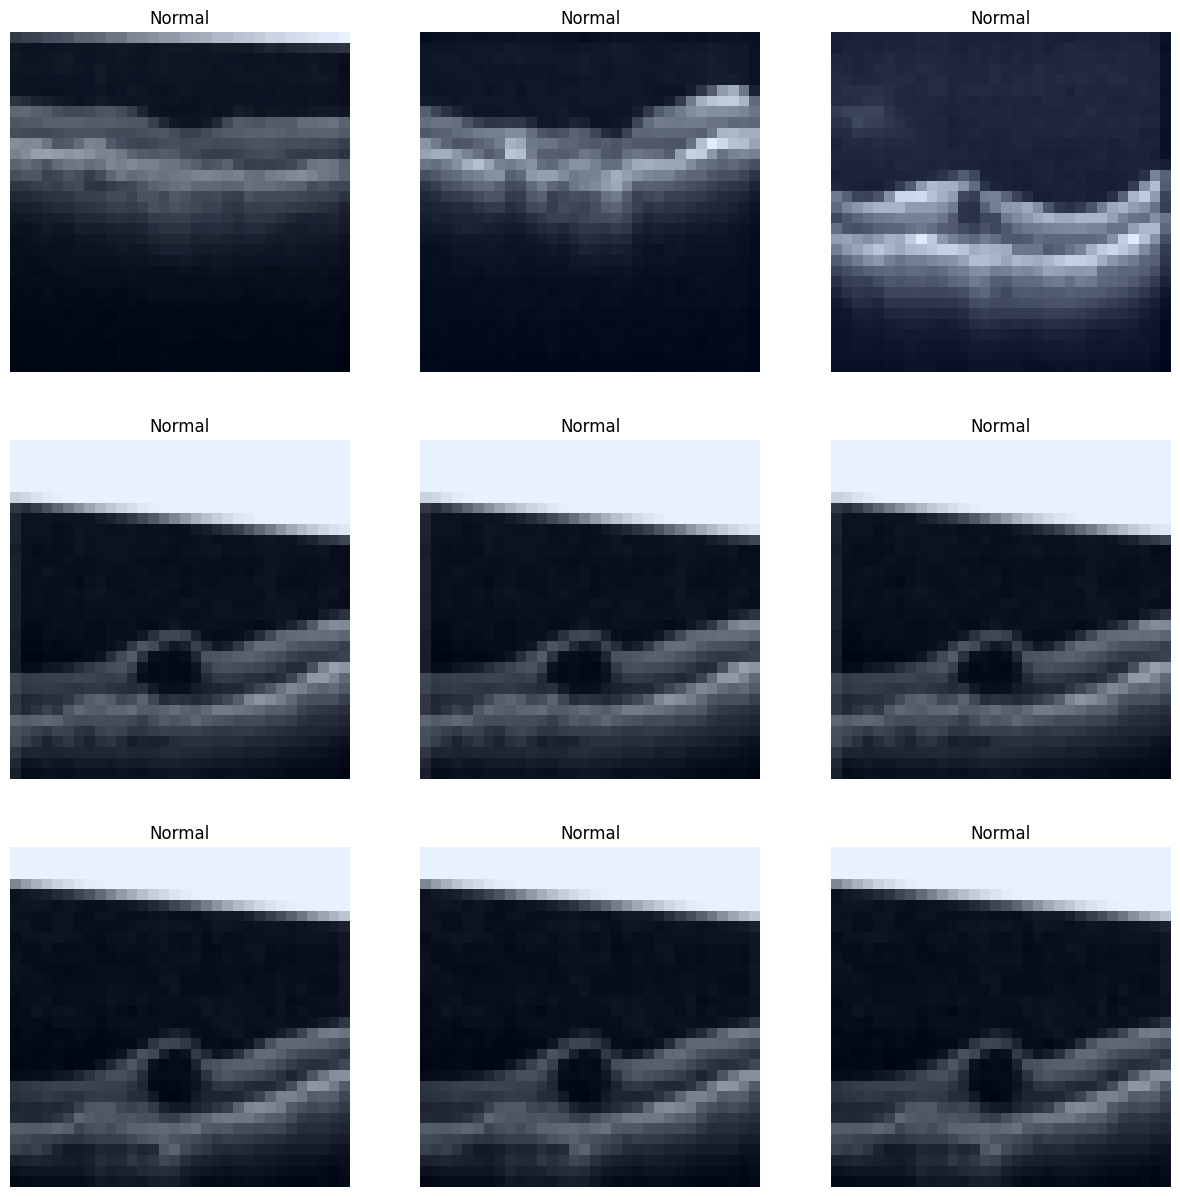

In [10]:
N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in 
                           [train_ds[i] for i in range(N_IMAGES)]])

classes = ['Normal', 'Drusen', 'DME', 'CNV']

plot_images(images, labels, classes)

In [11]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

Adapting the pre-trained ResNet-50 model to dataset, with the fully connected layer replaced to match the number of classes in Retinal OCT dataset.

In [12]:
pretrained_model = models.resnet50(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(train_ds.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
model = ResNet(resnet50_config, OUTPUT_DIM)
model.load_state_dict(pretrained_model.state_dict())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,516,228 trainable parameters


Having a large number of trainable parameters allows the model to capture complex patterns and relationships in the data, which can potentially lead to better performance. 

Setting up the device (CPU or CUDA) for running the models

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

Sets up a learning rate scheduler using the OneCycleLR scheduler from the PyTorc

In [15]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_iter)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

Below function used to evaluate the top-1 and top-k accuracy of a model's predictions during training or testing.

In [16]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

Below function is used to train the model for multiple epochs by calling it in a loop 

In [17]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

Below function is used to evaluate the model on a validation set to assess its performance.

In [18]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

Calculates the elapsed time between the start and end of an epoch:

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Training the model and saving the best model based on validation loss

In [20]:
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iter, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iter, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
       # print(epoch)
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 1m 2s
	Train Loss: 1.081 | Train Acc @1:  54.12% | Train Acc @5:  74.56%
	Valid Loss: 1.046 | Valid Acc @1:  56.25% | Valid Acc @5:  81.25%
Epoch: 02 | Epoch Time: 0m 50s
	Train Loss: 0.732 | Train Acc @1:  70.31% | Train Acc @5:  87.14%
	Valid Loss: 0.922 | Valid Acc @1:  59.38% | Valid Acc @5:  81.25%
Epoch: 03 | Epoch Time: 0m 51s
	Train Loss: 0.576 | Train Acc @1:  77.84% | Train Acc @5:  92.29%
	Valid Loss: 0.635 | Valid Acc @1:  65.62% | Valid Acc @5:  84.38%
Epoch: 04 | Epoch Time: 0m 51s
	Train Loss: 0.473 | Train Acc @1:  82.72% | Train Acc @5:  94.78%
	Valid Loss: 0.548 | Valid Acc @1:  75.00% | Valid Acc @5:  87.50%
Epoch: 05 | Epoch Time: 0m 50s
	Train Loss: 0.345 | Train Acc @1:  86.92% | Train Acc @5:  97.03%
	Valid Loss: 0.690 | Valid Acc @1:  68.75% | Valid Acc @5:  87.50%
Epoch: 06 | Epoch Time: 0m 50s
	Train Loss: 0.280 | Train Acc @1:  89.85% | Train Acc @5:  98.16%
	Valid Loss: 0.891 | Valid Acc @1:  71.88% | Valid Acc @5:  96.88%
Epoch: 07 |

Observations from the above output:

The training loss decreases with each epoch, indicating that the model is learning from the training data.
The training accuracy (@1 and @5) increases significantly, showing that the model is getting better at predicting the correct class.
The validation loss fluctuates but generally remains within a reasonable range.
The validation accuracy (@1 and @5) varies but shows some improvement over the epochs.

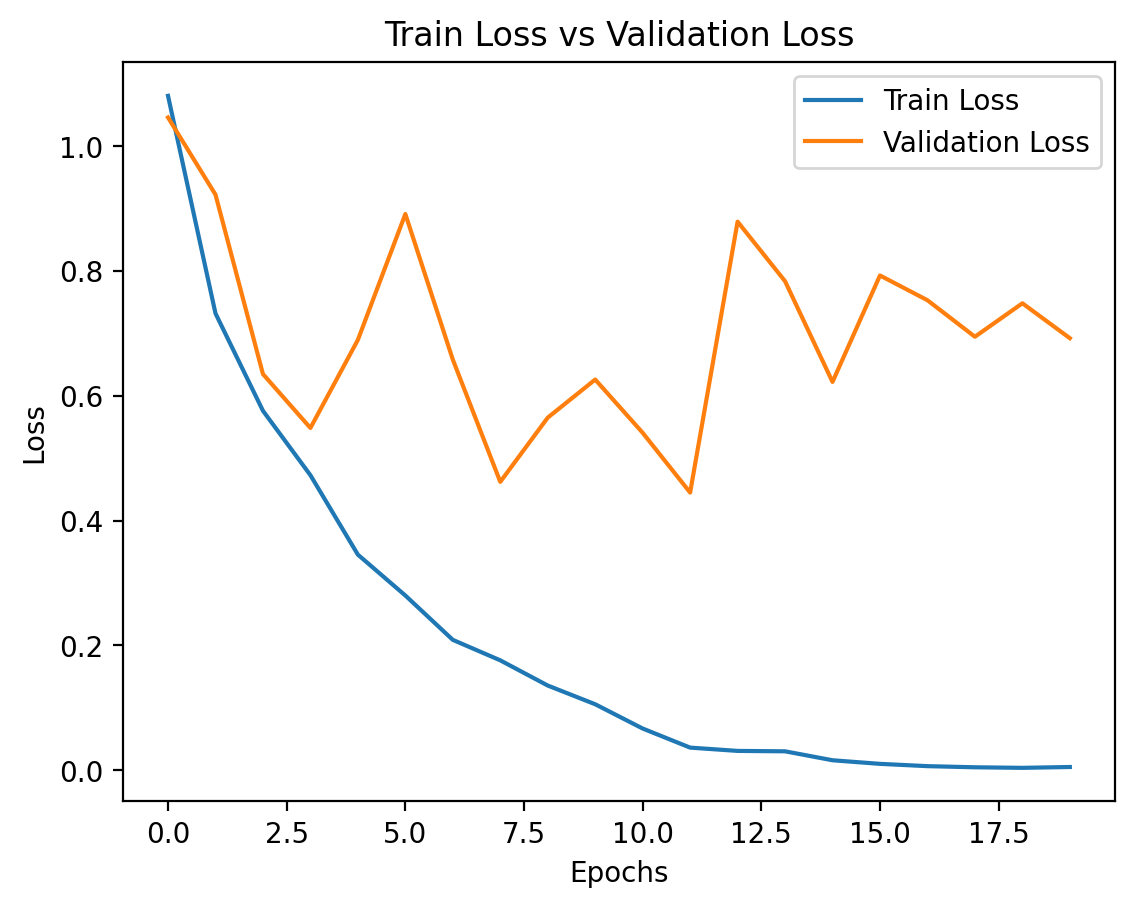

In [35]:
import matplotlib.pyplot as plt

# Plotting the train loss and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss vs Validation Loss')
plt.show()

In [22]:
# Getiing the predictions

def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [23]:
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

 Returns the predicted probabilities, predicted labels, and corresponding images and labels for the model 

In [24]:
images, labels, probs = get_predictions(model, test_iter)

Reading the ground truth file and storing into "test"

In [25]:
test = pd.read_csv('/content/drive/MyDrive/DeepLearning/Ground_Truth_Modified.csv', encoding='latin1')
y_test = np.array(test.drop(['Image'], axis=1))

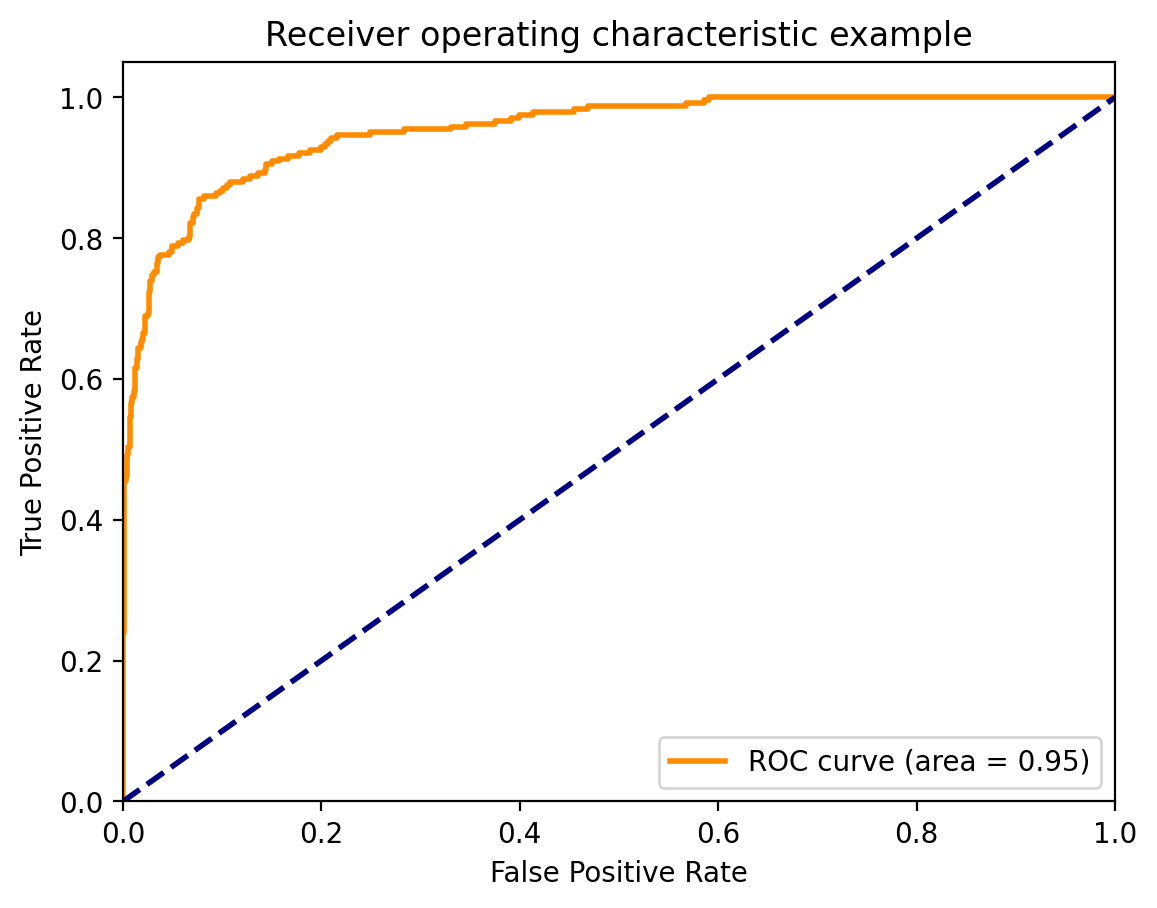

<ipython-input-26-a79737bcbebf>:47: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


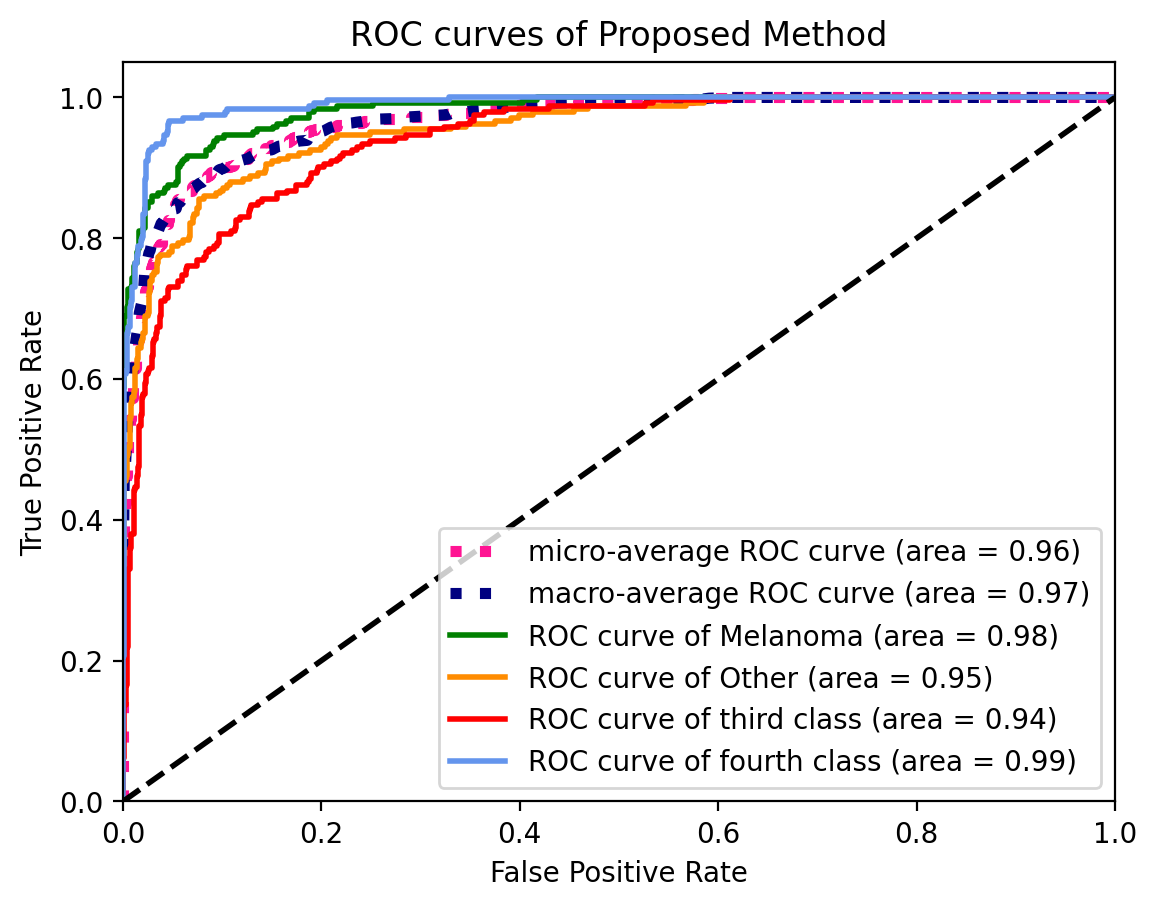

In [26]:
# ROC curves and AUC values 

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
#change to OneVsOneClassifier for generalized AUC
#from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

n_classes=4 # No of classes

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
    
plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of Melanoma (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of Other (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

# if you need more classes
plt.plot(fpr[2], tpr[2], color='red', lw=lw,
          label='ROC curve of third class (area = {1:0.2f})'
        ''.format(1, roc_auc[2]))

plt.plot(fpr[3], tpr[3], color='cornflowerblue', lw=lw,
          label='ROC curve of fourth class (area = {1:0.2f})'
          ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()

[[218  19   5   0]
 [ 15 203   9  15]
 [ 28  33 173   8]
 [  0   2  15 225]]
[0 1 2 3]
[242 242 242 242]
[[242. 242. 242. 242.]
 [242. 242. 242. 242.]
 [242. 242. 242. 242.]
 [242. 242. 242. 242.]]


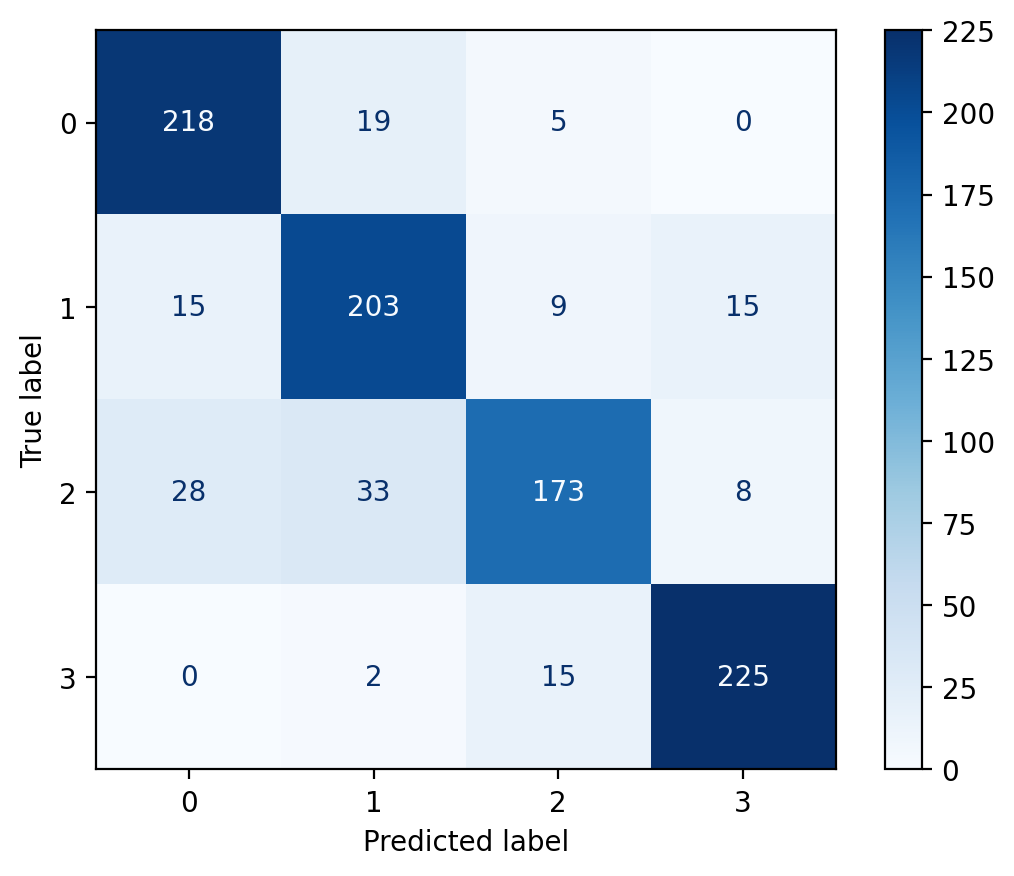

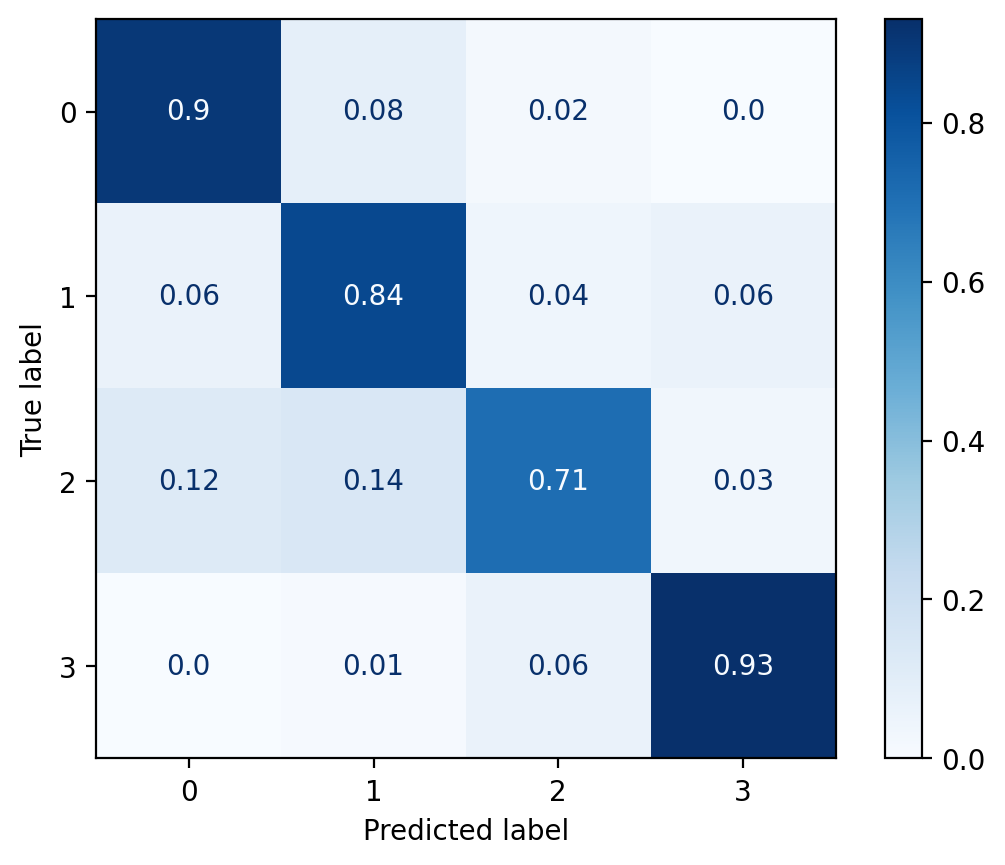

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize
from sklearn.metrics import ConfusionMatrixDisplay

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
print(class_names)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((4,4))
divisor[0][:] = 242
divisor[1][:] = 242
divisor[2][:] = 242
divisor[3][:] = 242
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

In [28]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

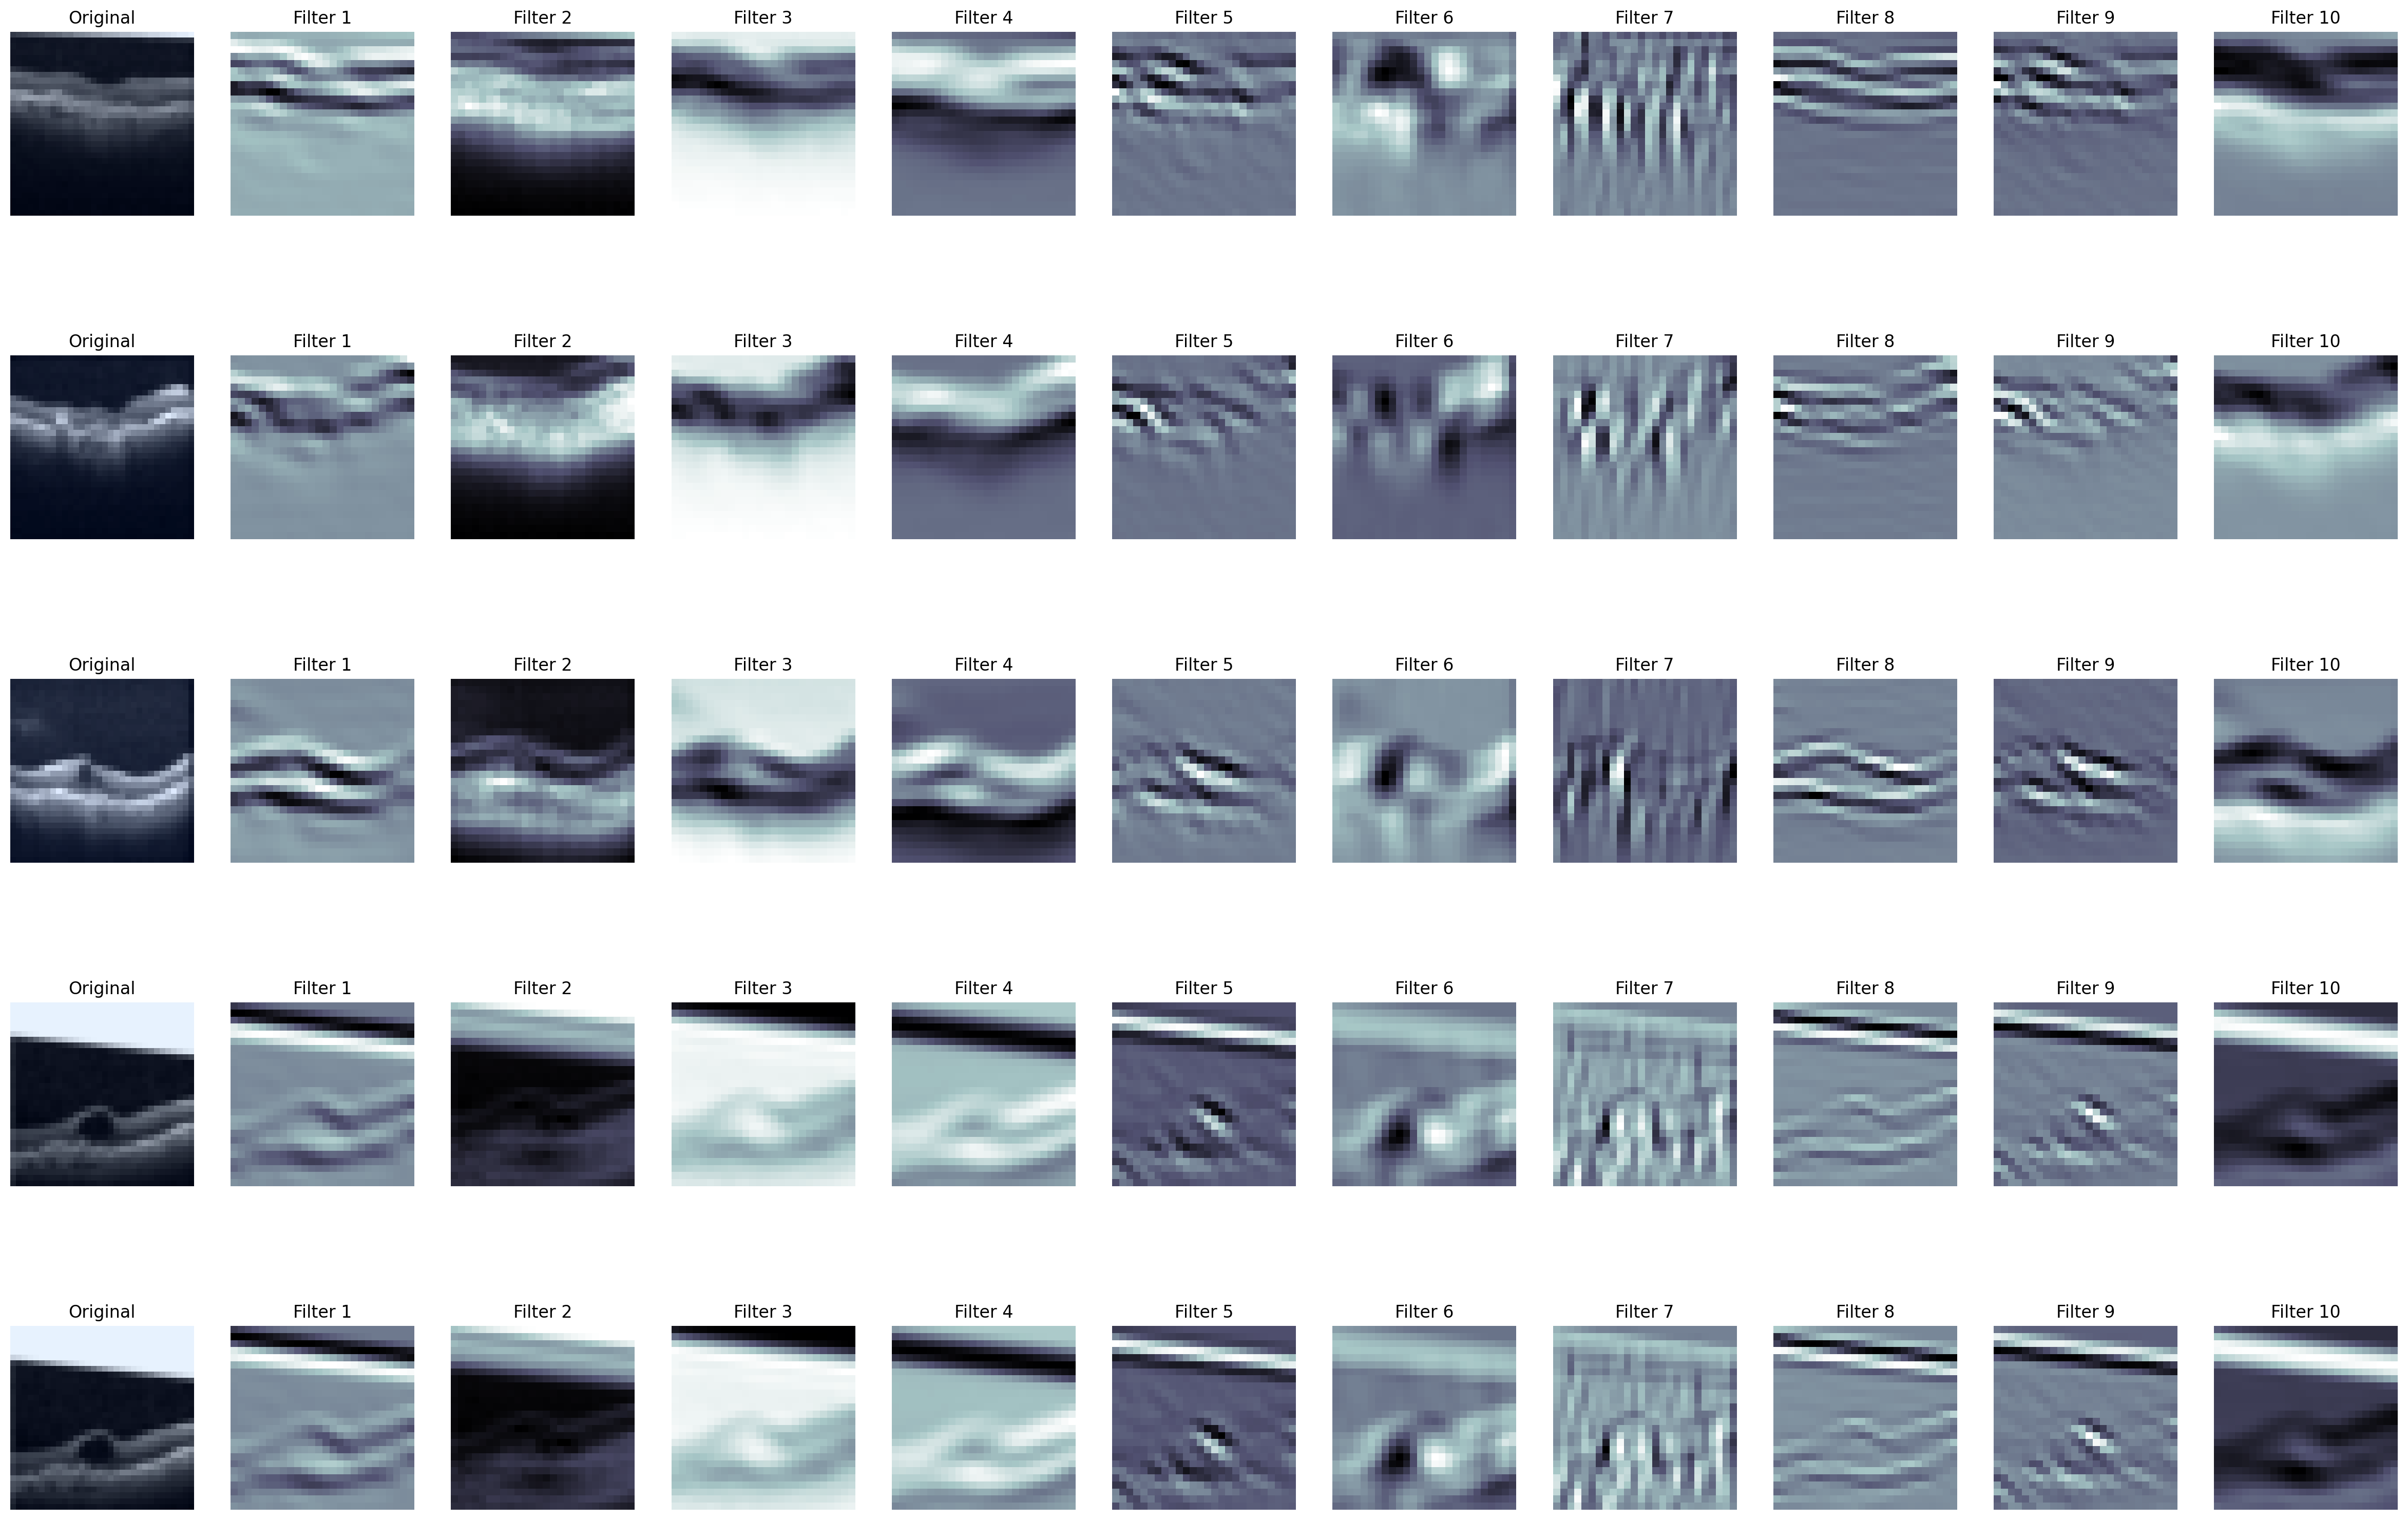

In [29]:
N_IMAGES = 5
N_FILTERS = 10

images = [image for image, label in [train_ds[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

In [30]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

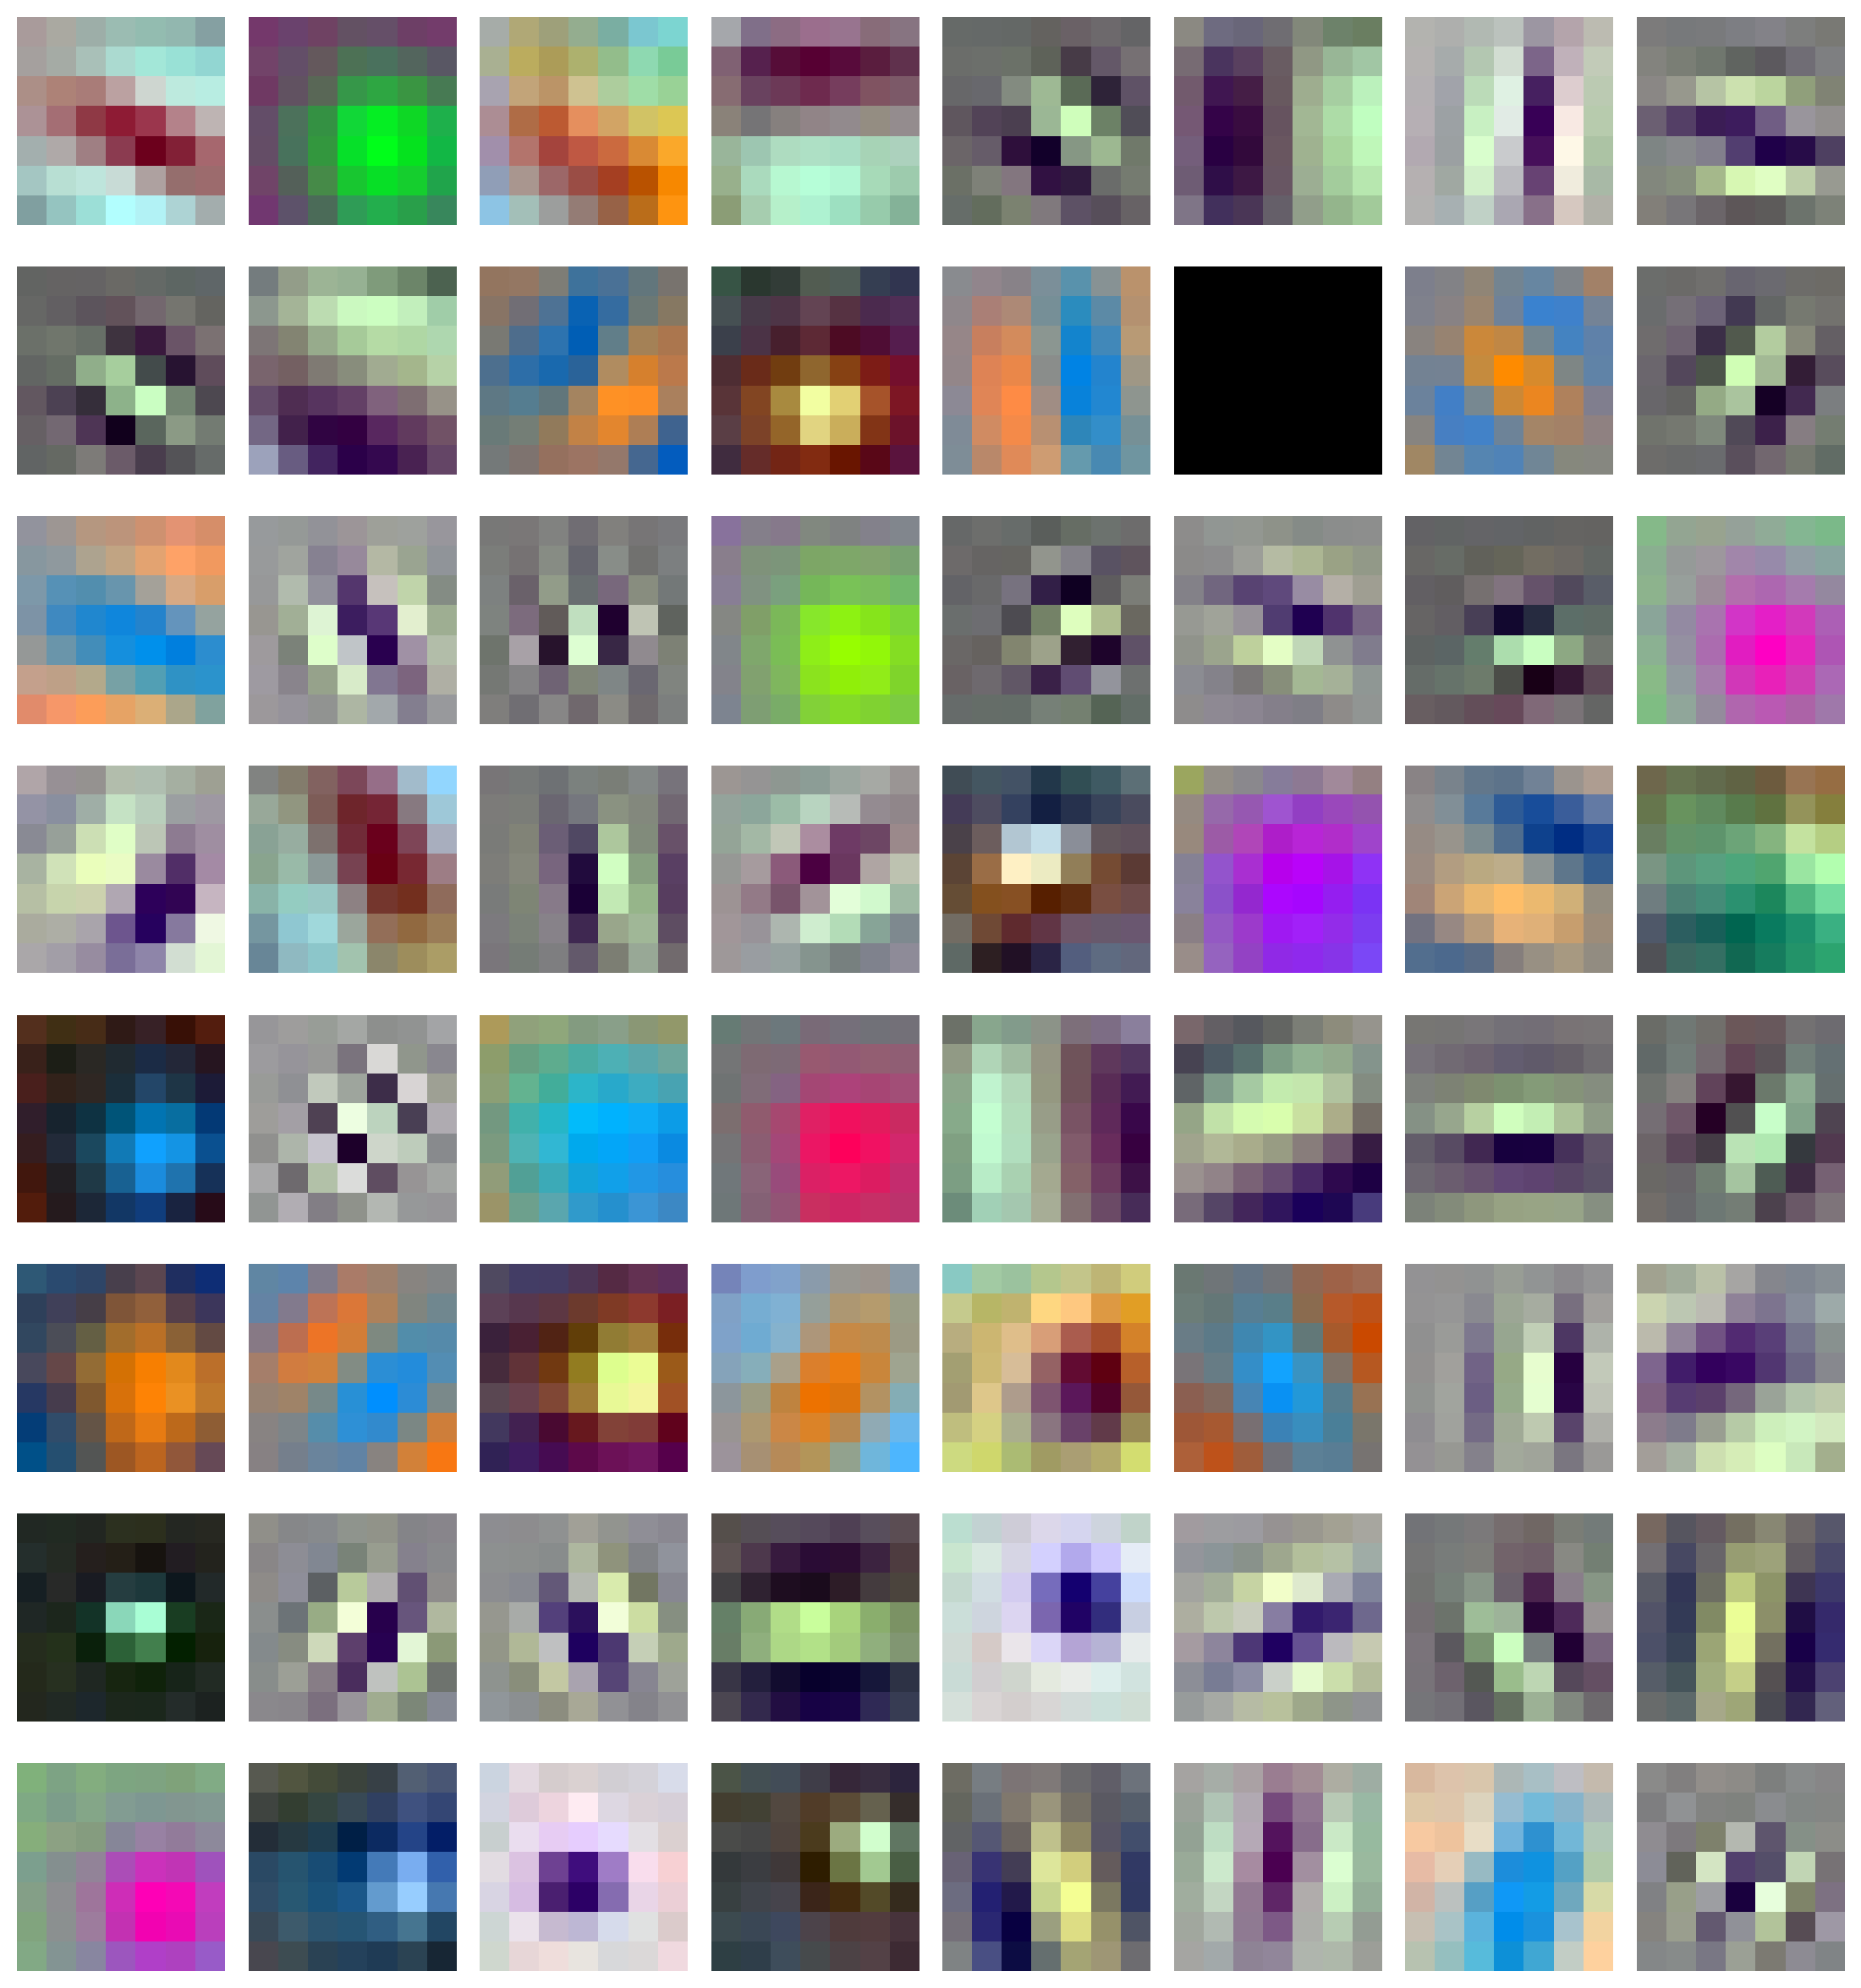

In [31]:
plot_filters(filters)

In [47]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

num_classes = 4

# Convert probabilities to predicted labels
y_pred_labels = np.argmax(probs, axis=1)

# Convert predicted labels to multilabel-indicator format
y_pred_labels_multilabel = label_binarize(y_pred_labels, classes=np.arange(num_classes))

# Calculate precision
precision = precision_score(y_test, y_pred_labels_multilabel, average='macro') * 100

# Calculate recall
recall = recall_score(y_test, y_pred_labels_multilabel, average='macro') * 100

# Calculate confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_labels_multilabel.argmax(axis=1))

# Calculate specificity
specificity = (cm[0, 0] / (cm[0, 0] + cm[0, 1])) * 100

# Calculate F1-score
f1 = f1_score(y_test, y_pred_labels_multilabel, average='macro') * 100

# Print the calculated metrics
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("Specificity: {:.2f}%".format(specificity))
print("F1-score: {:.2f}%".format(f1))

Precision: 84.72%
Recall: 84.61%
Specificity: 91.98%
F1-score: 84.45%
